<a href="https://colab.research.google.com/github/Kwanikaze/vpandas/blob/master/MRF_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np

# Load Data and Create Sample Datasets

In [14]:
# Function to create two datasets from global df that are one-hot encoded
def OHE_sample(sample_df, features_to_OHE: list):
  for feature in features_to_OHE:
    feature_OHE = pd.get_dummies(prefix = feature,data= sample_df[feature])
    sample_df = pd.concat([sample_df,feature_OHE],axis=1)
  sample_df.drop(features_to_OHE,axis=1,inplace=True)
  print(sample_df)
  return sample_df

In [15]:
# Load global relation
df = pd.read_csv("data_8.csv")
print(df.shape)

#Create two datasets containing AB and BC
num_samples = 1000
sample1_df = df[['A','B']].sample(n=num_samples, random_state=2)
print(sample1_df.head())
sample2_df = df[['B','C']].sample(n=num_samples, random_state=3)
print(sample2_df.head())

# Make A,B,C inputs all 8 bits
#Does data need to respect Gaussian distribution?
sample1_OHE = OHE_sample(sample1_df,['A','B'])
sample2_OHE = OHE_sample(sample2_df,['B','C'])

# Could onvert pandas dataframes to list of lists of lists
# [ [[OHE A1],[OHE B1]], [[OHE A2],[OHE B2]], ...  ]

(5056, 3)
      A  B
4333  7  6
2638  6  4
2254  4  4
3116  5  5
3998  6  6
      B  C
4616  7  6
2276  4  6
3448  5  4
4064  6  5
1204  2  3
      A_0  A_1  A_2  A_3  A_4  A_5  A_6  ...  B_1  B_2  B_3  B_4  B_5  B_6  B_7
4333    0    0    0    0    0    0    0  ...    0    0    0    0    0    1    0
2638    0    0    0    0    0    0    1  ...    0    0    0    1    0    0    0
2254    0    0    0    0    1    0    0  ...    0    0    0    1    0    0    0
3116    0    0    0    0    0    1    0  ...    0    0    0    0    1    0    0
3998    0    0    0    0    0    0    1  ...    0    0    0    0    0    1    0
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...
1857    0    1    0    0    0    0    0  ...    0    0    1    0    0    0    0
3813    0    0    0    0    0    1    0  ...    0    0    0    0    0    1    0
604     1    0    0    0    0    0    0  ...    1    0    0    0    0    0    0
621     1    0    0    0    0    0    0  ...    1    0    

# Global Relation Bayesian Network Ground Truth

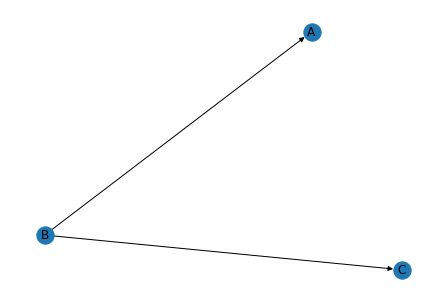

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Eliminating: B: 100%|██████████| 1/1 [00:00<00:00, 339.43it/s]


 Global Relation Ground Truth

 P(C|A=0) 
 Ground Truth
+------+----------+
| C    |   phi(C) |
+======+==========+
| C(0) |   0.2500 |
+------+----------+
| C(1) |   0.2500 |
+------+----------+
| C(2) |   0.2500 |
+------+----------+
| C(3) |   0.2500 |
+------+----------+
| C(4) |   0.0000 |
+------+----------+
| C(5) |   0.0000 |
+------+----------+
| C(6) |   0.0000 |
+------+----------+
| C(7) |   0.0000 |
+------+----------+


In [25]:
!pip install pgmpy==0.1.9
import pgmpy
import networkx as nx
from pgmpy.models import BayesianModel
from pgmpy.inference import VariableElimination

def groundTruth(df,evidence):
    """
    Extracts ground truth from global relation
    """
    model = BayesianModel([('B', 'A'), ('B', 'C')])
    model.fit(df)
    nx.draw(model, with_labels=True)
    plt.show()
    print('\n Global Relation Ground Truth')
    #for var in model.nodes():
    #    print(model.get_cpds(var))
    inference = VariableElimination(model)
    q = inference.query(variables=['A','B','C'])
    joint_prob = q.values.flatten()
    #print(joint_prob)
    #print('\n P(A,B,C) \n Ground Truth')
    #print(q)
    q = inference.query(variables=['C'], evidence=evidence)
    print('\n P(C|A=0) \n Ground Truth')
    print(q)

groundTruth(df,{'A':0})

# Create VAE-MRF Architecture

In [9]:
# VAE Parameters
latent_dims = 3
num_epochs = 2000
batch_size = 64
learning_rate = 1e-3
use_gpu = True
variational_beta = 0.00001 #tuned

In [10]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super().__init__()
        self.latent_dims = latent_dims
        self.fc1 = nn.Linear(num, latent_dims) # why have this additional fc layer?
        self.fc_mu = nn.Linear(latent_dims, latent_dims)
        self.fc_logvar = nn.Linear(latent_dims, latent_dims)
        #self.fc_mu = nn.Linear(num, latent_dims)
        #self.fc_logvar = nn.Linear(num, latent_dims)
        self.fc_out = nn.Linear(latent_dims,num)

    def encode(self, x):
        h1 = torch.sigmoid(self.fc1(x))
        return self.fc_mu(h1), self.fc_logvar(h1)
        #return torch.sigmoid(self.fc_mu(x)),torch.sigmoid(self.fc_logvar(x))

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        if z.size()[0] == self.latent_dims: #resize from [3] to [1,3]
          z = z.view(1, self.latent_dims)
        softmax = nn.Softmax(dim=1)
        recon = softmax(self.fc_out(z))
        return recon

    def forward(self, x, latent_dims):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

    def latent(self,x,latent_dims):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return z

    def sample(self, num_samples):
      # ignore latent_mu, latent_logvar, instead generate z values from standard normal
      z = torch.randn(num_samples, self.latent_dims)
      z = z.to(device)
      samples = self.decode(z)
      return samples

def vae_loss(batch_recon, x_batch_targets, mu, logvar):
  criterion = nn.CrossEntropyLoss()
  CE = criterion(batch_recon, x_batch_targets)
  #print(CE)
  KLd = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) # https://stats.stackexchange.com/questions/318748/deriving-the-kl-divergence-loss-for-vaes
  #print(KLd)
  return CE,variational_beta*KLd, CE + variational_beta*KLd

## Training
Requires alternating between AB and BC samples. Have a separate plate for each.
Need to learn Factors phi(A,B) and phi(B,C)